# TUTORIAL: 
# Data assimilation using real experimental data

We can now put everything we have learned together. 

We can investigate two scenarios:

A) Assume that we have access to the post-processed data and assimilate it. This situation simplifies the problem as the experimental data is not biased (see tutorial TA_azimuthal_data to see how the raw data is biased).
-   Truth: post-processed data 
-   Observations: post-processed data + noise (possibly coloured noise)

B) Assume a realistic setting in which the post-processed data is not available on the fly to input to the data assimilation algorithm. Here, we need to address the issue of biased observations.
-   Truth: post-processed data
-   Observations: raw data

In this tutorial we will work with option A. For option B go to the tutorial ```11_DA_annular_raw.ipynb```.

In [27]:
import numpy as np
import os

from matplotlib import pyplot as plt

from essentials.physical_models import Annular
from essentials.bias_models import ESN
rng = np.random.default_rng(0)


if os.path.isdir('/mscott/'):
    data_folder = '/mscott/an553/data/'  # set working directory to 
else:
    data_folder = "../data/"

## 1. Load data 
Create the reference truth and the observations.

The function ```create_truth``` is a compact form of the code below
```
  
# Load experimental data
mat = sio.loadmat(filename + '.mat')
y_true, y_raw, t_true = [mat[key].squeeze() for key in ['y_filtered', 'y_raw', 't']]

t_max = 7.
i1 = np.argmin(abs(t_true - t_max))
y_true, y_raw, t_true = [xx[:i1] for xx in [y_true, y_raw, t_true]]
t_true -= t_true[0]

Nt, Nq = y_true.shape
dt_t = t_true[1] - t_true[0]

# Sample the observations
obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + 1, Nt_obs, dtype=int)
y_obs, t_obs = [xx[obs_idx] for xx in [y_raw, t_true]]
```


In [28]:
from essentials.create import create_truth
ER = 0.4875 + 0.025 * 2 # 0.4875 + np.arange(0, 4) * 0.025

t_start = Annular.t_transient
t_stop = t_start + Annular.t_CR * 15

truth = create_truth(model = data_folder + 'annular/ER_{}'.format(ER),
                     t_start = t_start,
                     t_stop = t_stop,
                     Nt_obs = 35,
                     t_max = t_stop + Annular.t_transient,
                     post_processed=False
                     )


The output ```truth``` is a dictionary containing
```
dict(y_raw=y_raw, y_true=y_true, t=t_true, dt=dt_t, 
     t_obs=t_obs, y_obs=y_obs, dt_obs=Nt_obs * dt_t, std_obs=std_obs)
```

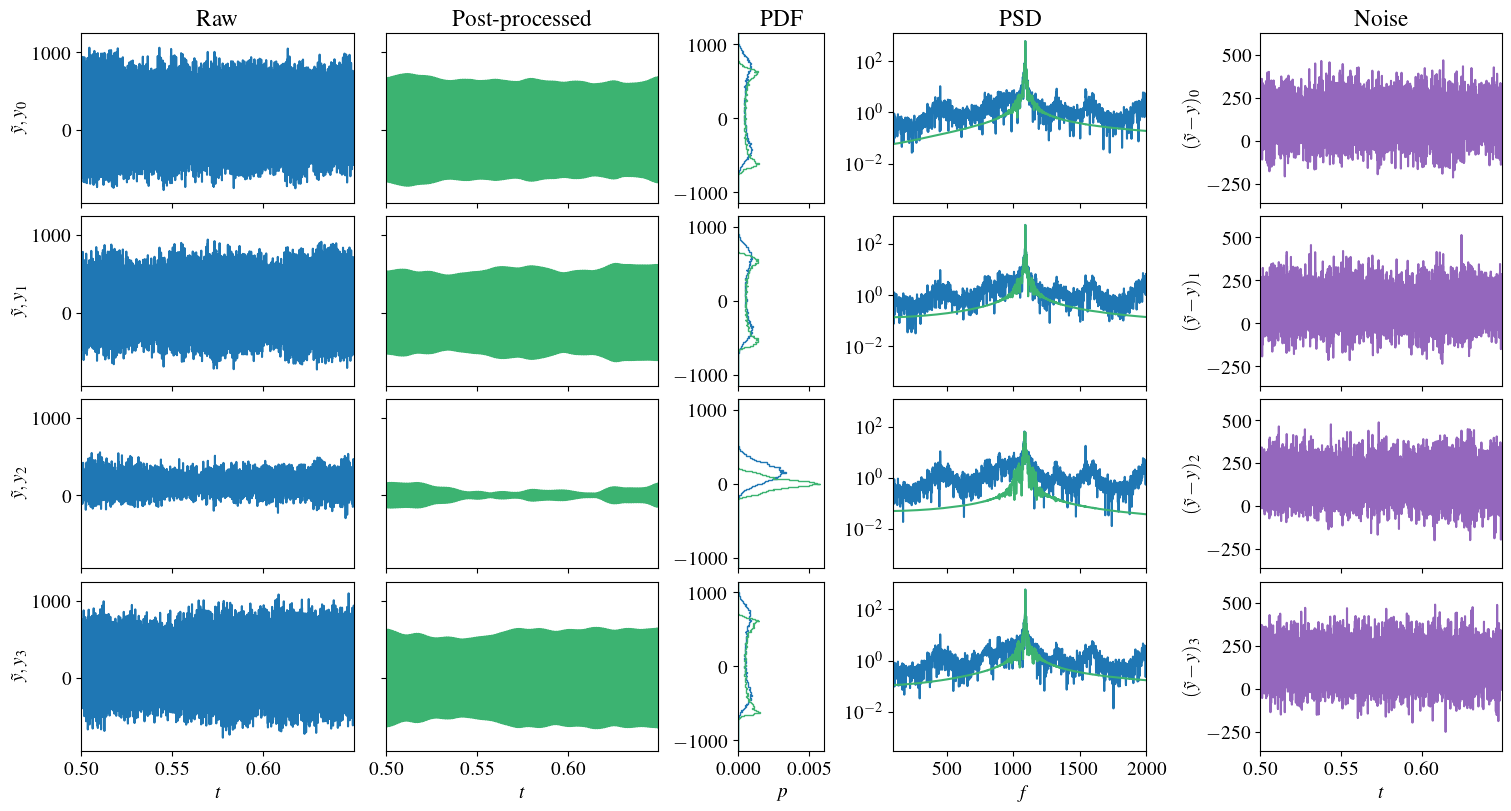

In [29]:
from essentials.plotResults import plot_truth
plot_truth(**truth)

## 2. Define the forecast model
This is the physical model which we will use to model the true data.
Here, we select the filter parameters and create ensemble

*The function ```create_ensemble``` consists of* 

```
alpha0_mean = dict()
for alpha, lims in alpha0.items():
    alpha0_mean[alpha] = 0.5 * (lims[0] + lims[1])

ensemble = Annular(**alpha0_mean)

filter_params = dict(m= 20, 
                     std_psi=0.3,
                     std_a=alpha0)

# Forecast model to initialise the ensemble after transient
state, t_ = ensemble.time_integrate(int(ensemble.t_CR / ensemble.dt))
ensemble.update_history(state[-1], reset=True)

ensemble.init_ensemble(**filter_params)
ensemble.close()
```

In [30]:
from essentials.create import create_ensemble
alpha0 = dict(nu=(-15., 30.),
              c2beta=(10, 50),
              kappa=(1.E-4, 2.E-4),
              epsilon=(5e-3, 8e-3),
              omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
              theta_b=(0.5, 0.7),
              theta_e=(0.4, 0.6)
              )

forecast_params = dict(model=Annular, 
                       dt=truth['dt'], 
                       m=50, 
                       std_psi=0.3, 
                       std_a=alpha0
                       )

ensemble = create_ensemble(**forecast_params)

In [31]:
print(truth['dt'])
print(ensemble.t_transient / 3.)


1.953125e-05
0.16666666666666666


In [32]:
# Visualize ensemble initialization
# from essentials.plotResults import plot_ensemble
# plot_ensemble(ensemble, reference_params={'kappa': 1e-4, 'omega': 2 * np.pi, 'epsilon': 1e-3})

## 4. Train an ESN to model the model bias
The procedure is the following

&emsp; i. Initialise ESN Bias class object
&emsp; ii. Create synthetic bias to use as training data 
&emsp; iii. Train the ESN
&emsp; iv. Create washout data

<br><br>
**4.1. Initialise the ESN**

In [33]:
from essentials.create import create_bias_training_dataset

ensemble_ESN = ensemble.copy()

train_params = dict(bias_model=ESN, 
                    upsample=5,
                    N_units=50,
                    N_wash=10,
                    t_train=ensemble.t_transient / 3.,
                    t_test=ensemble.t_CR * 2,
                    t_val=ensemble.t_CR * 2,
                    # Training data generation options
                    augment_data=True,
                    biased_observations=True,
                    seed_W=0,
                    N_folds=4,
                    L=50,
                    std_a=alpha0,
                    # Hyperparameter search ranges
                    rho_range=(0.5, 1.),
                    sigma_in_range=(np.log10(1e-5), np.log10(1e1)),
                    tikh_range=[1e-12, 1e-9]
                    )

ensemble_ESN.init_bias(**train_params)


|
**4.2. Create training data**

The details of the code inside ```create_bias_training_dataset()``` function is explained in the tutorial ```Class_Bias.ipynb```.

In [34]:

# train_data = np.load('train_data', allow_pickle=True)
train_data = create_bias_training_dataset(truth['y_raw'],
                                          truth['y_true'], ensemble_ESN, **train_params)
# 
# np.save('train_data', train_data)


Visualize training data


In [35]:
#TODO



**4.3. Train the ESN**

The training convergence, hyperparameter optimization and testing results are saved in a pdf file in *figs_ESN* folder.


 ----------------- HYPERPARAMETER SEARCH ------------------
 4x4 grid and 4 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 5.000e-01	 1.000e-05	 1.000e-09	 -3.6513
2	 5.000e-01	 1.000e-03	 1.000e-09	 -3.5819
3	 5.000e-01	 1.000e-01	 1.000e-09	 -3.4744
4	 5.000e-01	 1.000e+01	 1.000e-12	 -2.8564
5	 6.667e-01	 1.000e-05	 1.000e-09	 -3.6304
6	 6.667e-01	 1.000e-03	 1.000e-09	 -3.5593
7	 6.667e-01	 1.000e-01	 1.000e-12	 -3.4415
8	 6.667e-01	 1.000e+01	 1.000e-12	 -2.9079
9	 8.333e-01	 1.000e-05	 1.000e-09	 -3.6232
10	 8.333e-01	 1.000e-03	 1.000e-09	 -3.5402
11	 8.333e-01	 1.000e-01	 1.000e-12	 -3.5139
12	 8.333e-01	 1.000e+01	 1.000e-12	 -2.9038
13	 1.000e+00	 1.000e-05	 1.000e-09	 -3.6233
14	 1.000e+00	 1.000e-03	 1.000e-12	 -3.5344
15	 1.000e+00	 1.000e-01	 1.000e-09	 -3.2921
16	 1.000e+00	 1.000e+01	 1.000e-12	 -3.0371
17	 5.377e-01	 6.133e-05	 1.000e-09	 -3.6281
18	 9.880e-01	 6.553e-05	 1.000e-09	 -3.5609
19	 7.911e-01	 1.224e-02	 1.000e-09	 -3.5016
20	 5.000e

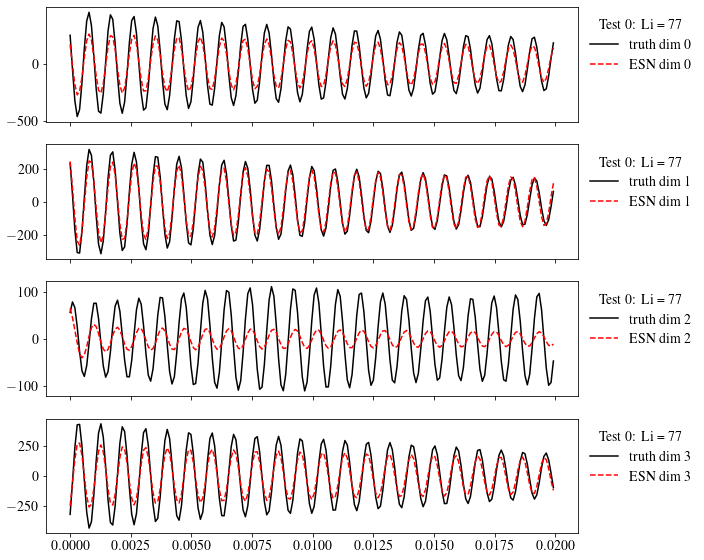

In [36]:
ensemble_ESN.bias.train_bias_model(**train_data)

**4.4. Create washout data**

We retrieve from the raw data a ```N_wash``` number of observations to use for initialising the ESN, i.e., to perform the washout. 
The ESN initialization must be before the fist observation.

```
from essentials.create import create_washout
wash_t, wash_obs = create_washout(ensemble.bias, t=t_true, y_raw=y_raw)
```

In [37]:
ensemble_ESN.bias.t_init = truth['t_obs'][0] - 2 * truth['dt_obs']

i1 = np.argmin(abs(ensemble_ESN.bias.t_init - truth['t']))
i0 = i1 - ensemble_ESN.bias.N_wash  * ensemble_ESN.bias.upsample 

wash_obs = truth['y_raw'][i0:i1 + 1:ensemble_ESN.bias.upsample]
wash_t = truth['t'][i0:i1 + 1:ensemble_ESN.bias.upsample]


## 5. Apply data assimilation
We now have all the ingredients to start our data assimilation algorithm.

In [38]:
t_start = Annular.t_transient
t_stop = t_start + Annular.t_CR * 35


truth_og = create_truth(model = data_folder + 'annular/ER_{}'.format(ER),
                     t_start = t_start,
                     t_stop = t_stop,
                     Nt_obs = 30,
                     t_max = t_stop + Annular.t_transient,
                     post_processed=False
                     )

truth['wash_obs'] = wash_obs
truth['wash_t'] = wash_t


In [39]:
rng = np.random.default_rng(6)

forecast_params['m'] = 20
forecast_params['std_a'] = dict(nu=(-10., 20.),
                                c2beta=(10, 50),
                                kappa=(1.E-4, 2.E-4),
                                epsilon=(5e-3, 8e-3),
                                omega=(1090 * 2 * np.pi, 1095 * 2 * np.pi),
                                theta_b=(0.5, 0.7),
                                theta_e=(0.4, 0.6)
                                )

filter_ensemble = create_ensemble(**forecast_params)

In [40]:
from essentials.DA import *
from essentials.Util import save_to_pickle_file

truth = truth_og.copy()
# save_to_pickle_file(results_dir + '', truth, out, bias, ensemble)

out = []
 # --------------
name = 'simulation_output_all'


ens_bb = filter_ensemble.copy()
ens_bb.t_init = truth['t_obs'][0]
ens_bb.inflation = 1.0
ens_bb.reject_inflation = 1.0

ens_ba = ens_bb.copy()
ens_ba.bias = ensemble_ESN.bias.copy()


DA_kwargs = dict(y_obs=truth['y_obs'].copy(), t_obs=truth['t_obs'].copy(), std_obs=0.1, wash_obs=wash_obs.copy(), wash_t=wash_t.copy())

for kf in ['rBA_EnKF', 'EnKF']:
    
    if kf[0] == 'r':
        ks = np.linspace(0, 5, 6)
        blank_ens = ens_ba.copy()
    else:
        ks = [None]
        blank_ens = ens_bb.copy()

    blank_ens.filter = kf
    for kk in ks:
        ens = blank_ens.copy()
        
        if kf[0] == 'r':
            ens.regularization_factor = kk

        
        filter_ens = dataAssimilation(ens, **DA_kwargs.copy())
        
        #Forecast the ensemble further without assimilation
        Nt_extra = int(filter_ens.t_CR / filter_ens.dt) * 10
        
        psi, t = filter_ens.time_integrate(Nt_extra)
        filter_ens.update_history(psi, t)
        
        y = filter_ens.get_observable_hist(Nt_extra)
        b, t_b = filter_ens.bias.time_integrate(t=t, y=y)
        filter_ens.bias.update_history(b, t_b)
        
        filter_ens.close()
        
        out.append(filter_ens.copy())

results_dir = 'results/ER{}/m{}/'.format(ER, out[0].m)
os.makedirs(results_dir, exist_ok=True)
save_to_pickle_file(results_dir + name, truth, out, ensemble_ESN.bias, ensemble)


 ------------------ Annular Model Parameters ------------------ 
	 ER = 0.5
	 Nq = 4
	 c2beta = 20.88
	 dt = 1.95313e-05
	 epsilon = 0.0023
	 kappa = 0.00012
	 n = 1.0
	 nu = -14.505
	 omega = 6848.67
	 theta_b = 0.63
	 theta_e = 0.66

 ---------------- ESN bias model parameters --------------- 
	 L = 50
	 N_ens = 1
	 N_units = 50
	 N_wash = 10
	 bayesian_update = False
	 biased_observations = True
	 connect = 3
	 observed_idx = [4 5 6 7]
	 perform_test = True
	 rho = 0.5
	 sigma_in = 1e-05
	 t_train = 0.166667
	 t_val = 0.02
	 tikh = 1e-09
	 update_reservoir = False
	 upsample = 5

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = rBA_EnKF  
	 bias = ESN 
 	 m = 20 
 	 Time steps between analysis = None 
 	 Inferred params = ['nu', 'c2beta', 'kappa', 'epsilon', 'omega', 'theta_b', 'theta_e'] 
 	 Inflation = 1.0 
 	 Ensemble std(psi0) = 0.3
 	 Ensemble std(alpha0) = {'nu': (-10.0, 20.0), 'c2beta': (10, 50), 'kappa': (0.0001, 0.0002), 'epsilon': (0.005, 0.

            omega         nu            c2beta       kappa            epsilon          theta_b        theta_e
----------  ------------  ------------  -----------  ---------------  ---------------  -------------  -------------
Truth       $6848.672$    $9.261375$    $30.56625$   $0.00012$        $0.0023$         $0.63$         $0.66$
rBA_EnKF    $6861.9804    $-7.1118814   $36.800855   $0.0001482383    $0.006094497     $0.59702732    $0.52551187
 w/ ESN      \pm 1.355$    \pm 2.544$    \pm 8.132$   \pm 1.84e-05$    \pm 0.0006685$   \pm 0.03344$   \pm 0.02756$
rBA_EnKF    $6841.9208    $8.2789514    $47.547797   $0.00014071617   $0.0057185143    $0.53943464    $0.49576619
 w/ ESN      \pm 0.9889$   \pm 3.33$     \pm 6.921$   \pm 1.811e-05$   \pm 0.0005441$   \pm 0.01656$   \pm 0.01288$
rBA_EnKF    $6840.7681    $11.925336    $40.282835   $0.00014772038   $0.0062758822    $0.53515607    $0.5124341
 w/ ESN      \pm 0.9412$   \pm 3.116$    \pm 6.388$   \pm 1.738e-05$   \pm 0.0005372$   \pm 

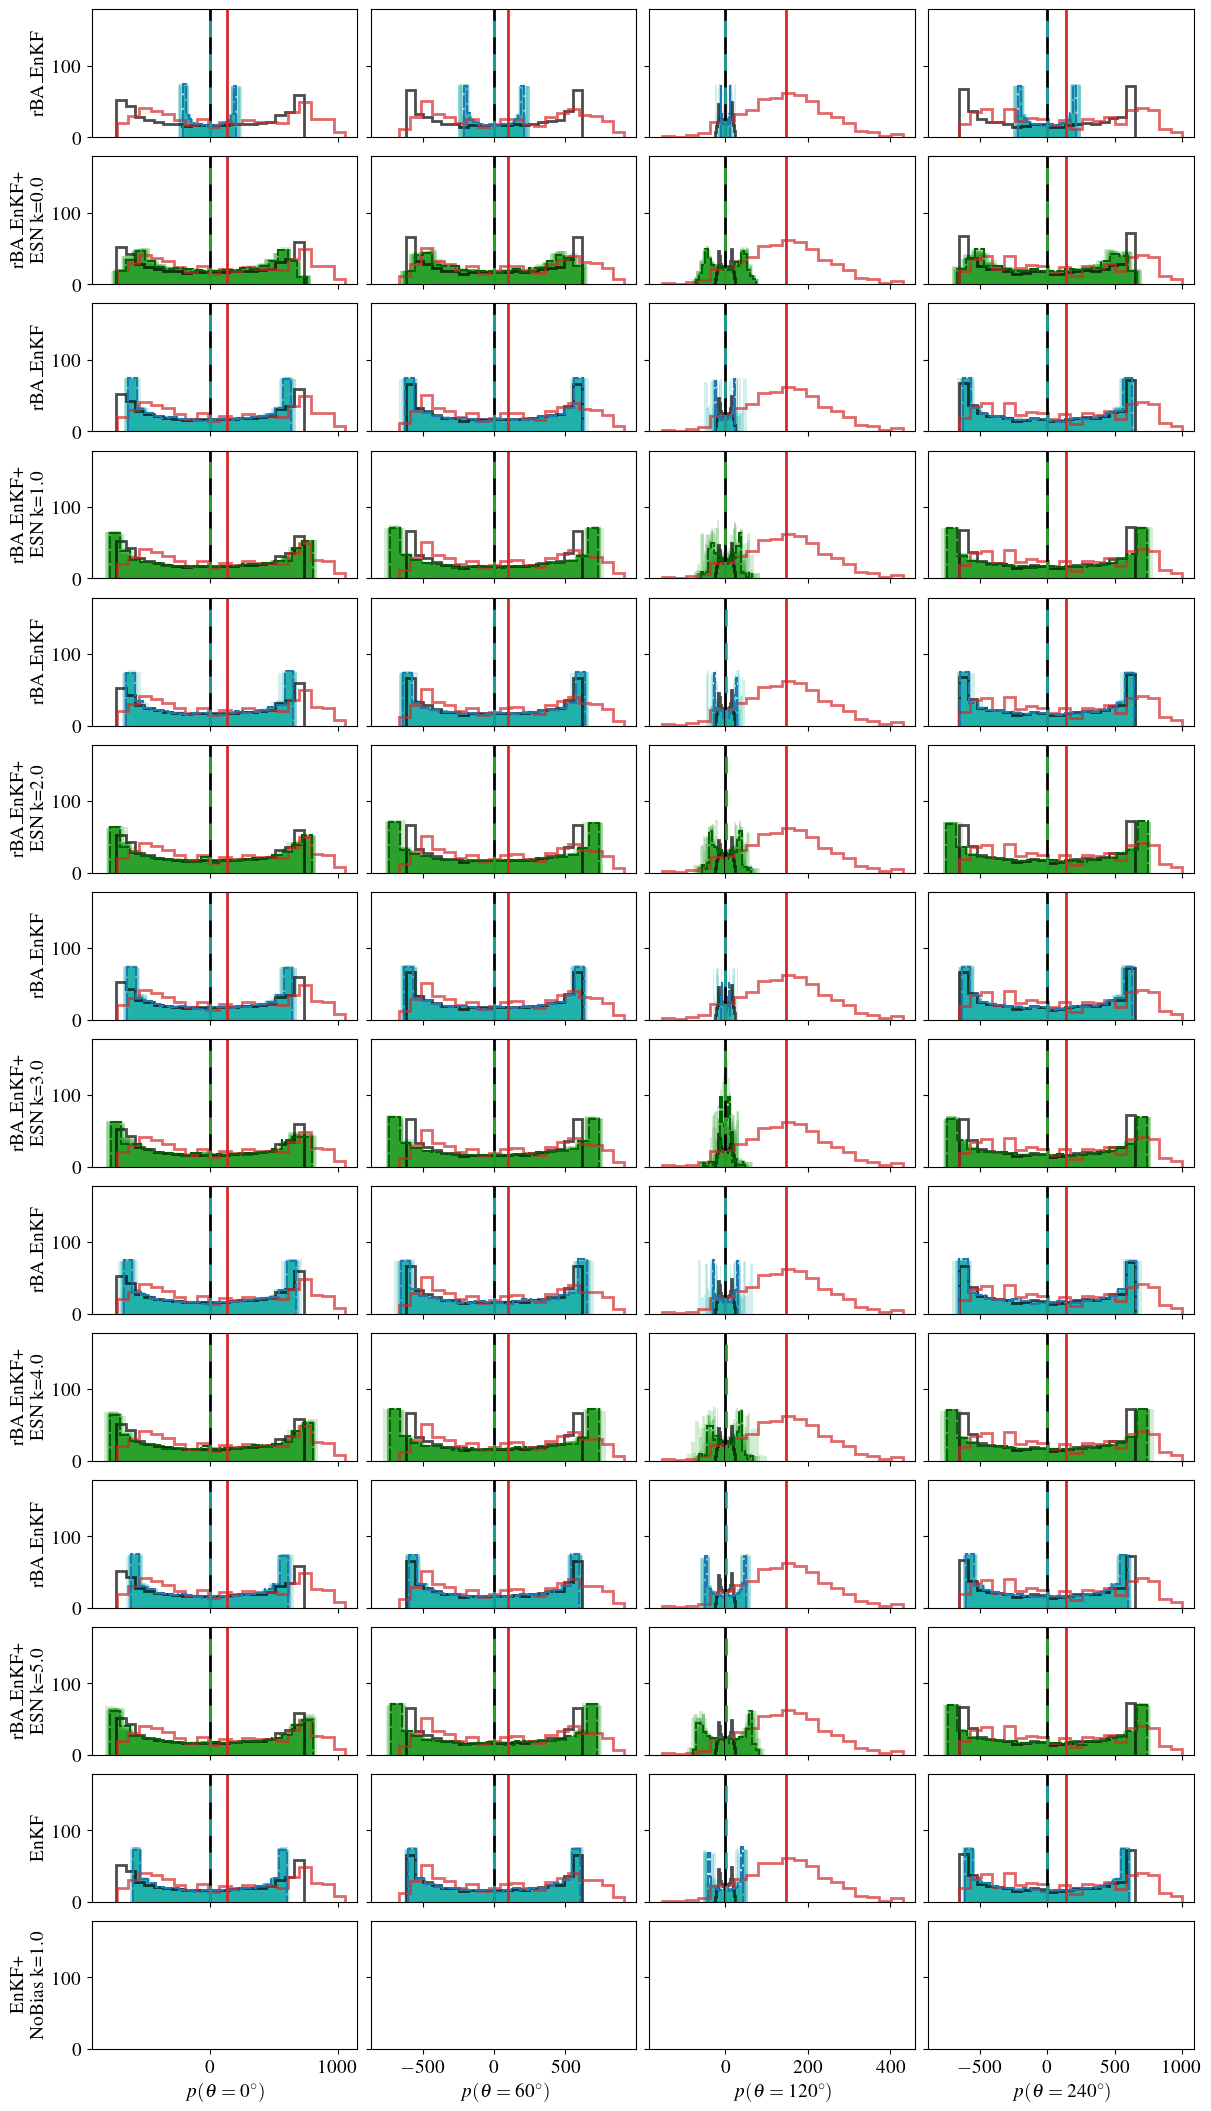

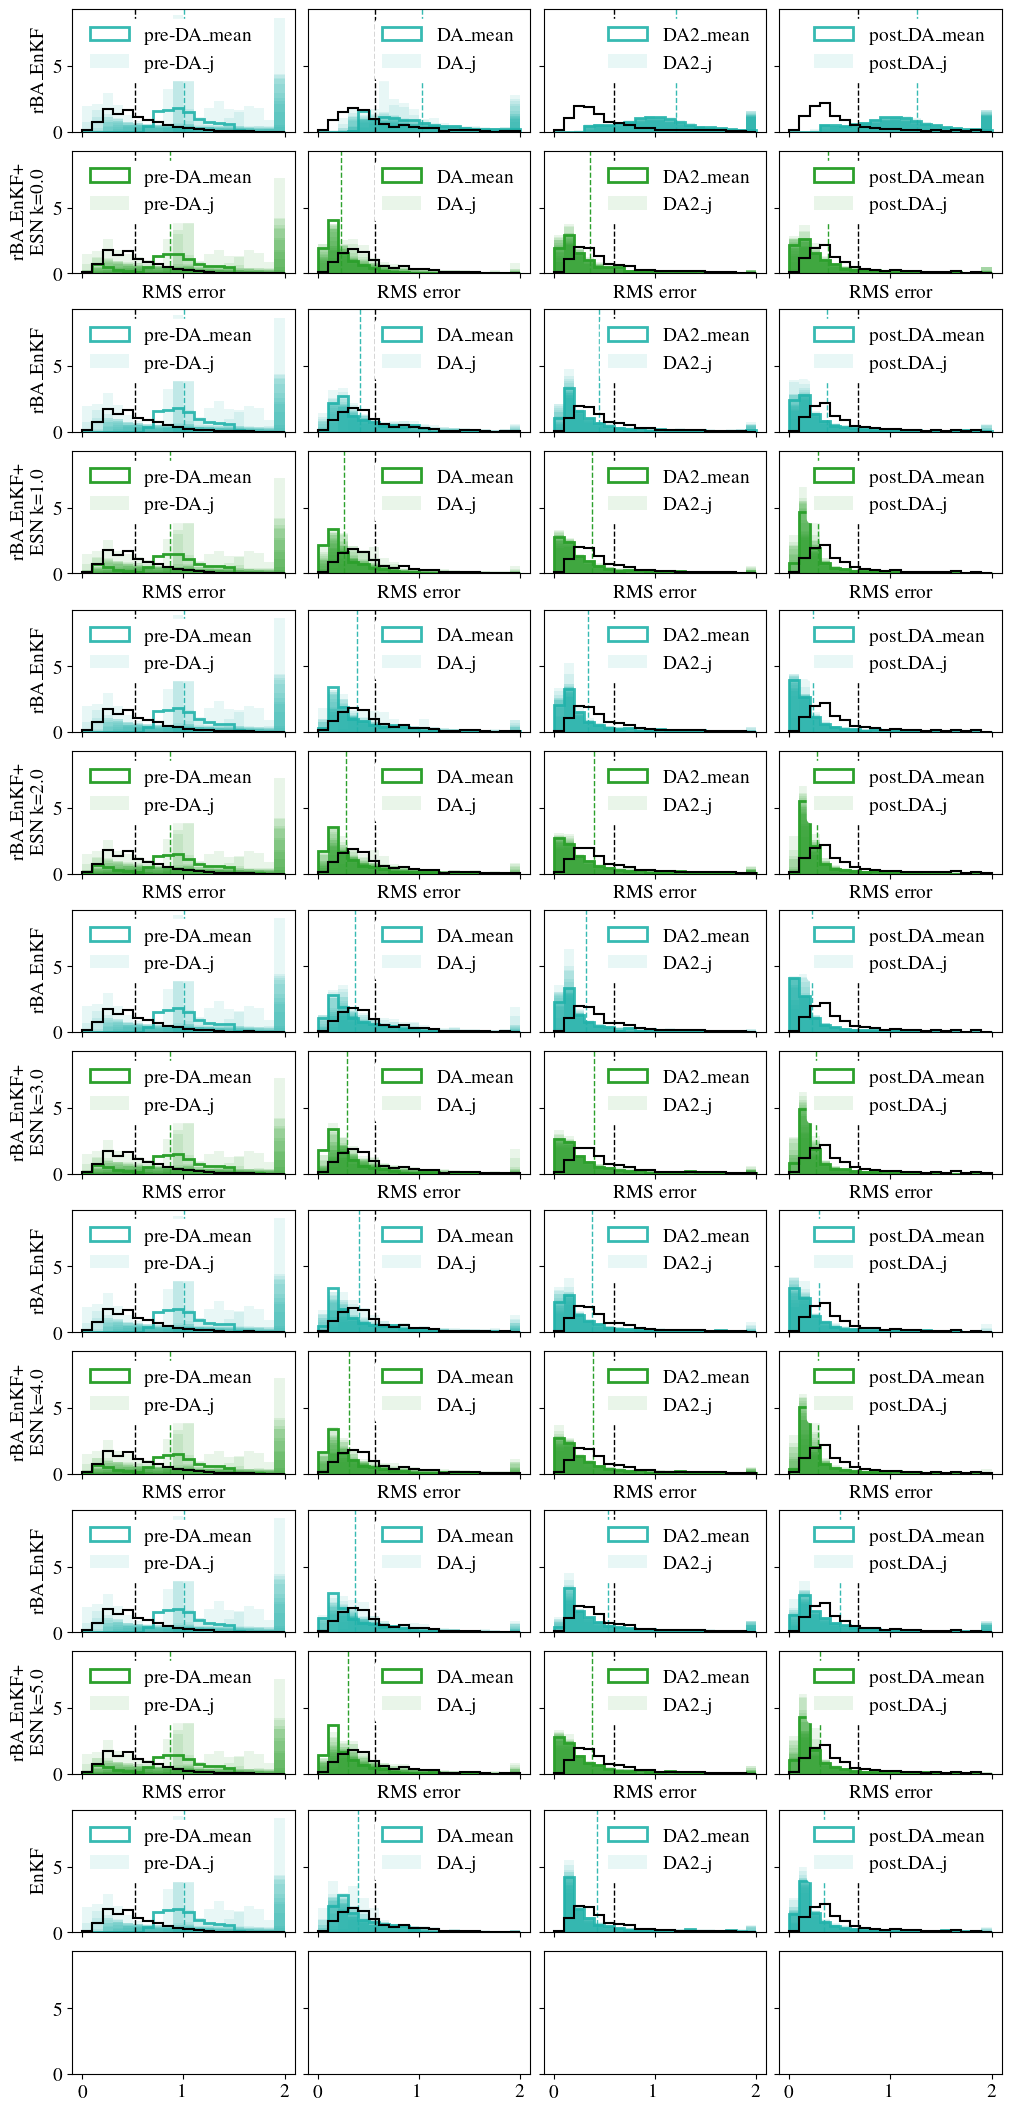

In [41]:
from essentials.plotResults import print_parameter_results
from essentials.plotResults import plot_states_PDF, plot_RMS_pdf

truth_params = dict()
for param in Annular.params:
    if param == 'nu':
        truth_params[param] = Annular.nu_from_ER(ER)
    elif param == 'c2beta':
        truth_params[param] = Annular.c2beta_from_ER(ER)
    else:
        truth_params[param] = Annular.defaults[param]

print_parameter_results(out, true_values=truth_params)
               
truth['wash_t'] = wash_t
truth['wash_obs'] = wash_obs

windows = [(truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 1),
           (truth['t_obs'][-1], truth['t_obs'][-1] + out[0].t_CR * 5)]

for window, sub in zip(windows, ['short']):
    plot_states_PDF(out, truth, nbins=20, window=window)
    plt.savefig(results_dir + 'plot_states_PDF_' + sub + '.pdf')


plot_RMS_pdf(out, truth, nbins=20)
plt.savefig(results_dir + 'plot_RMS_pdf' + '.pdf')

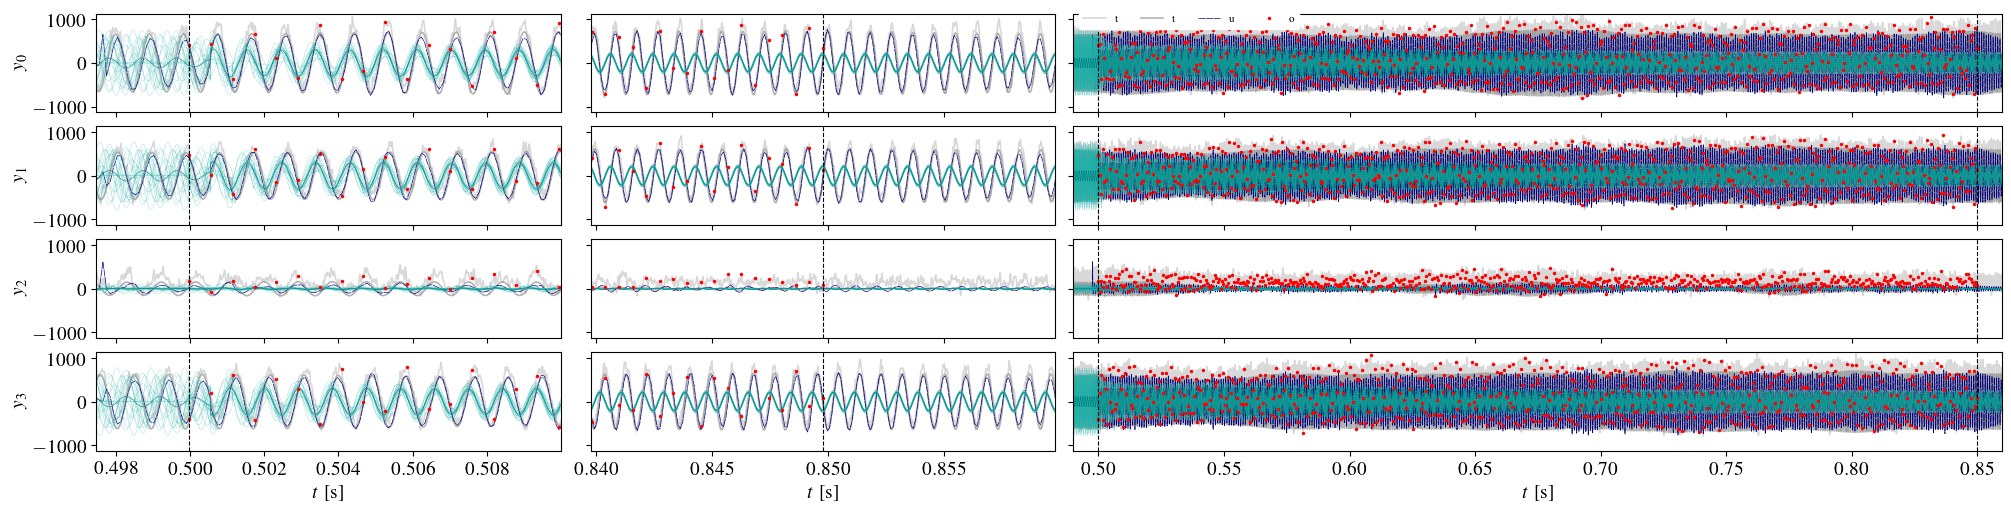

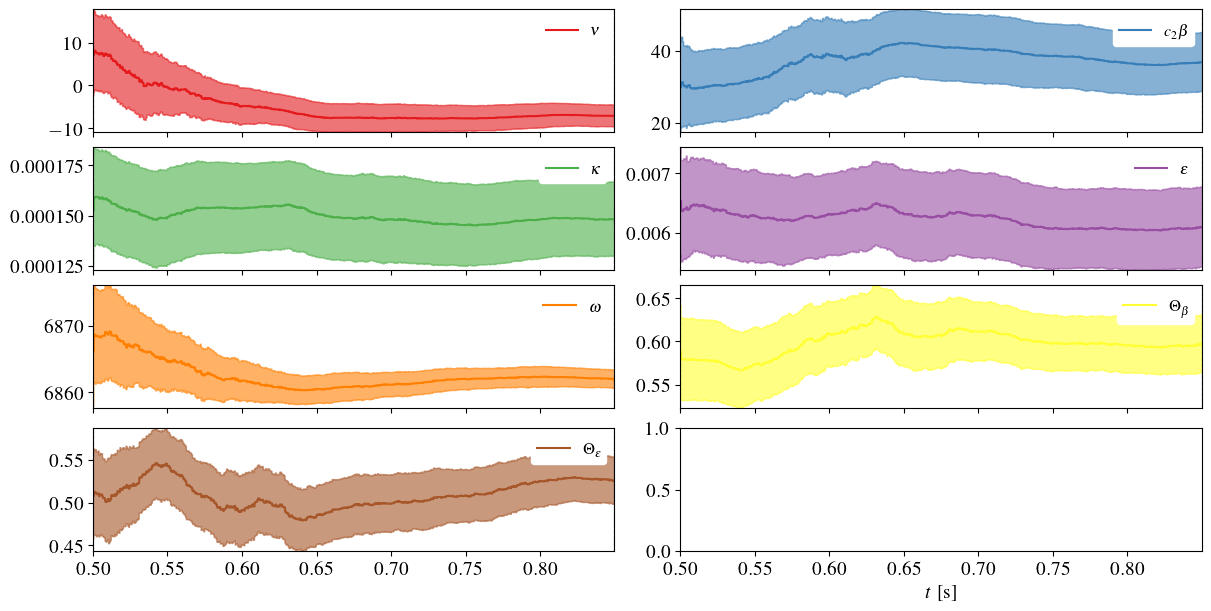

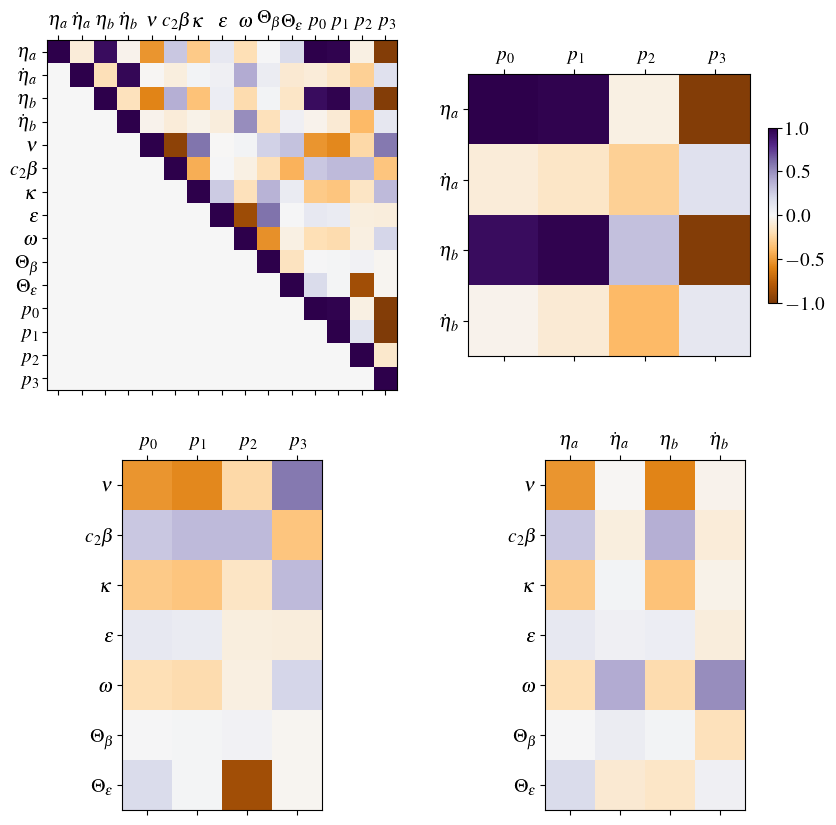

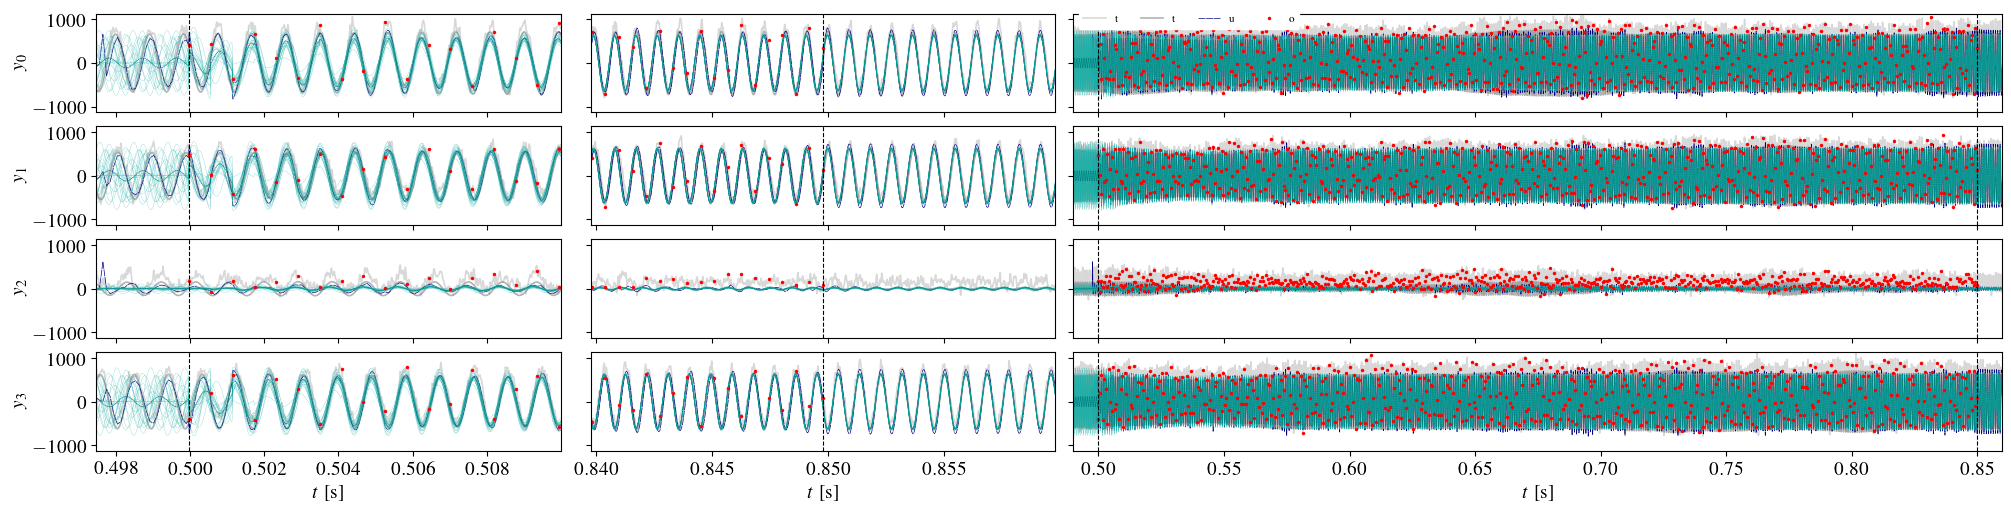

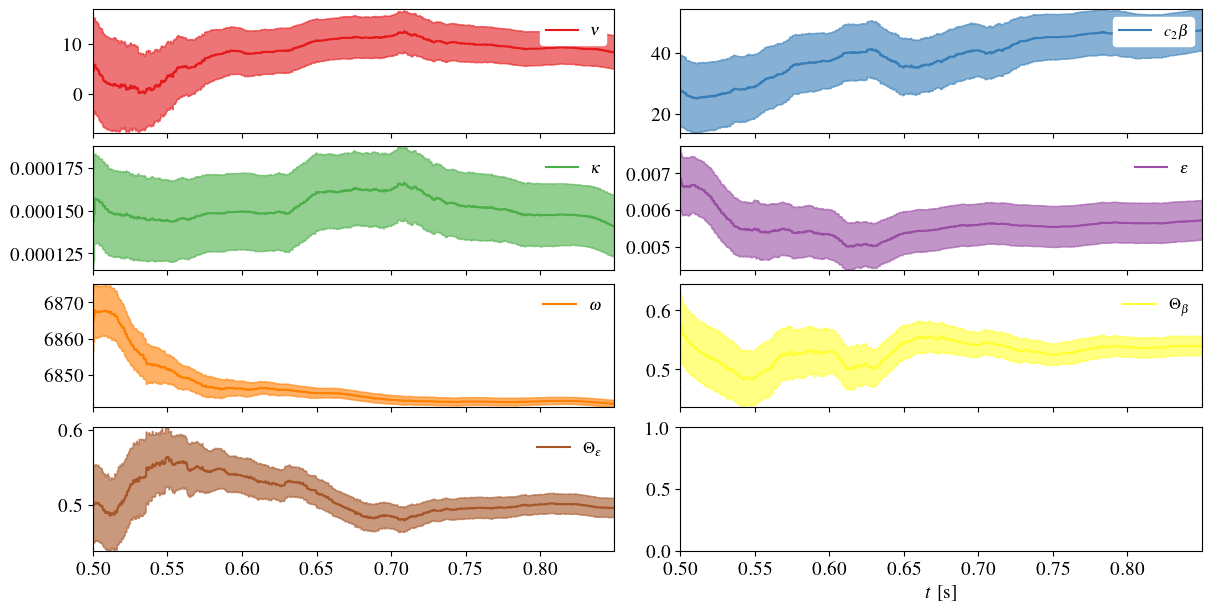

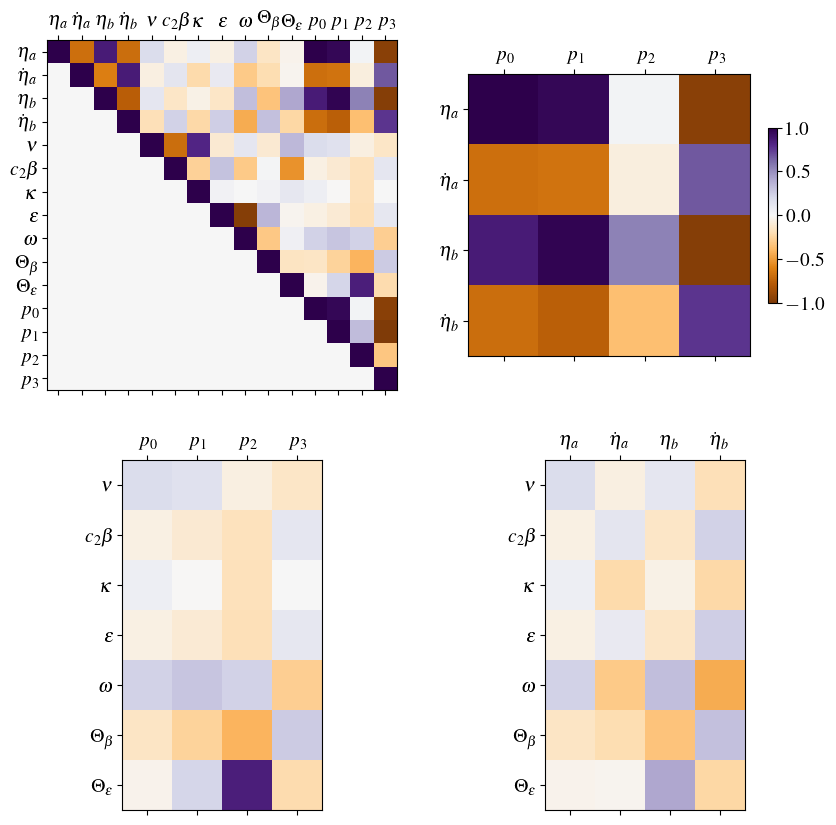

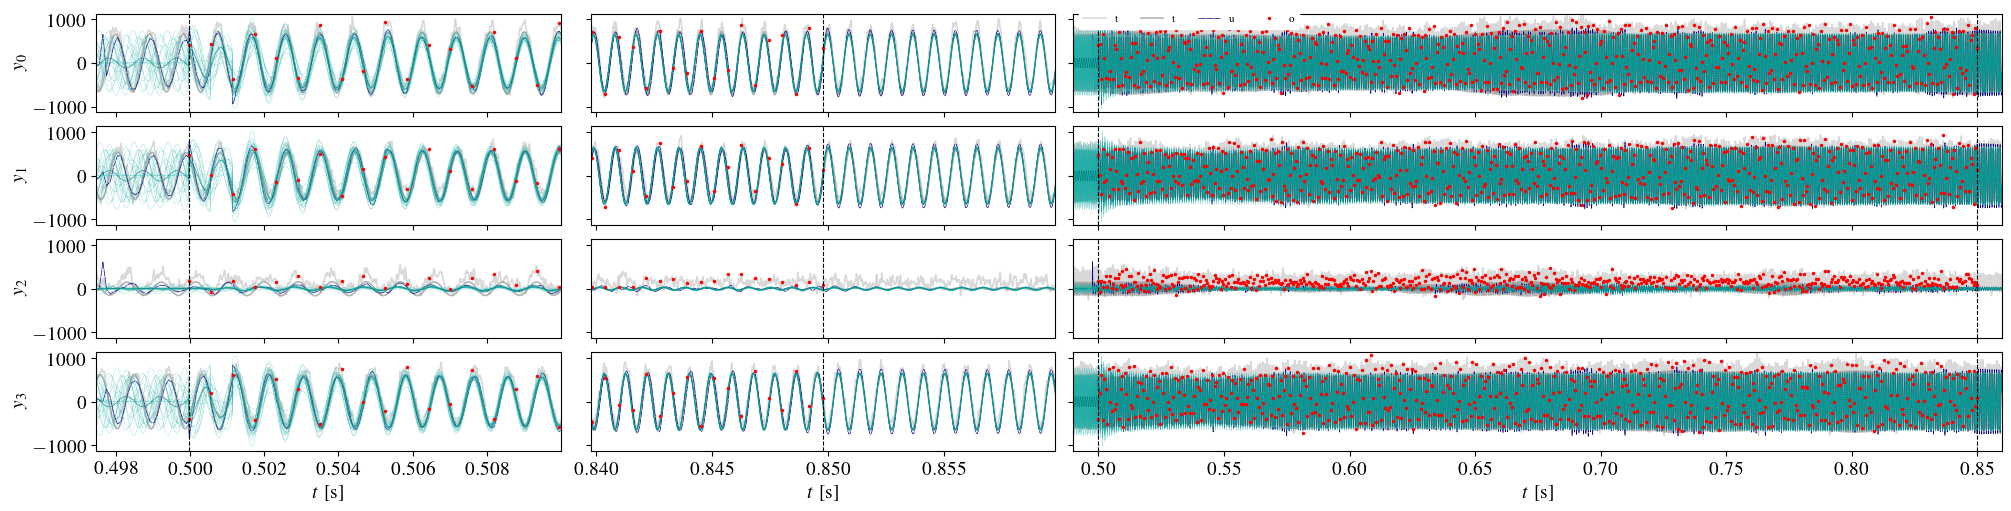

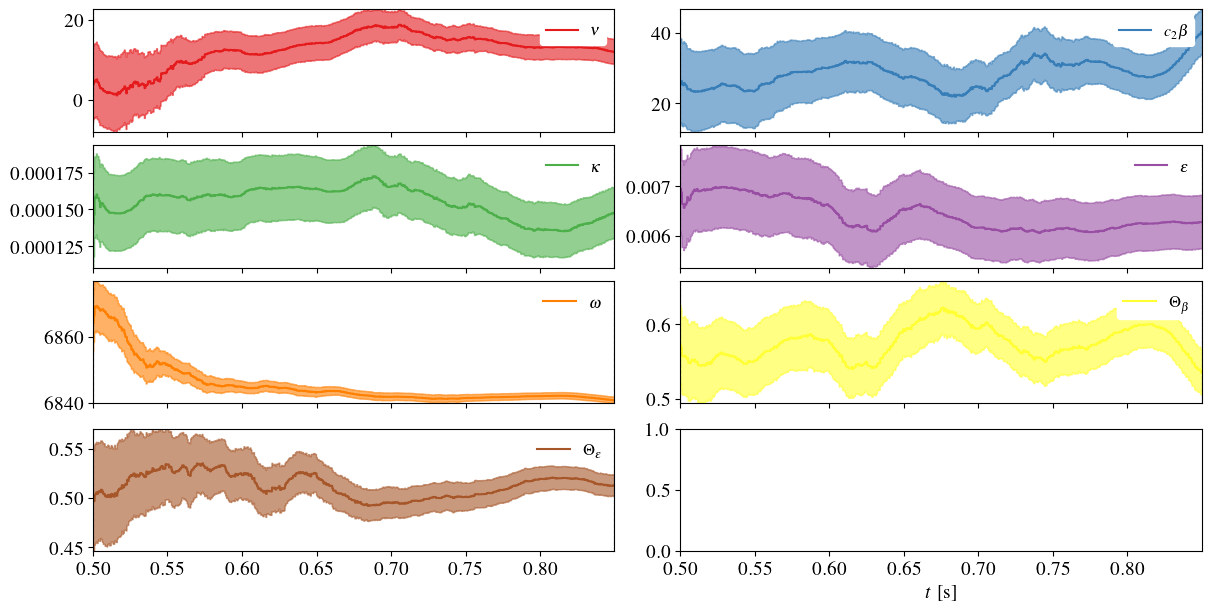

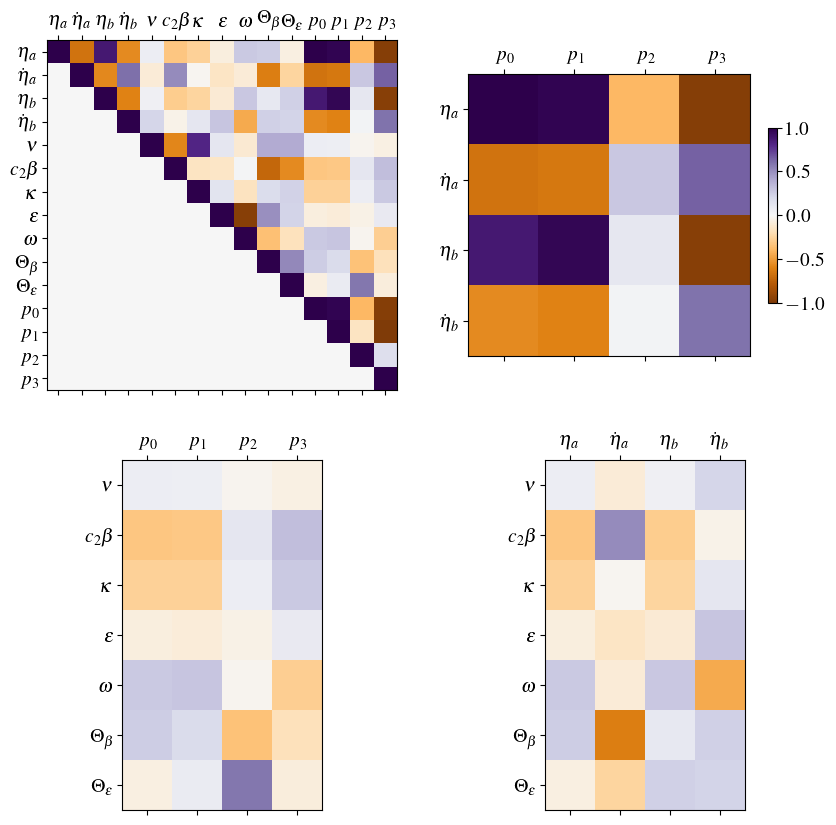

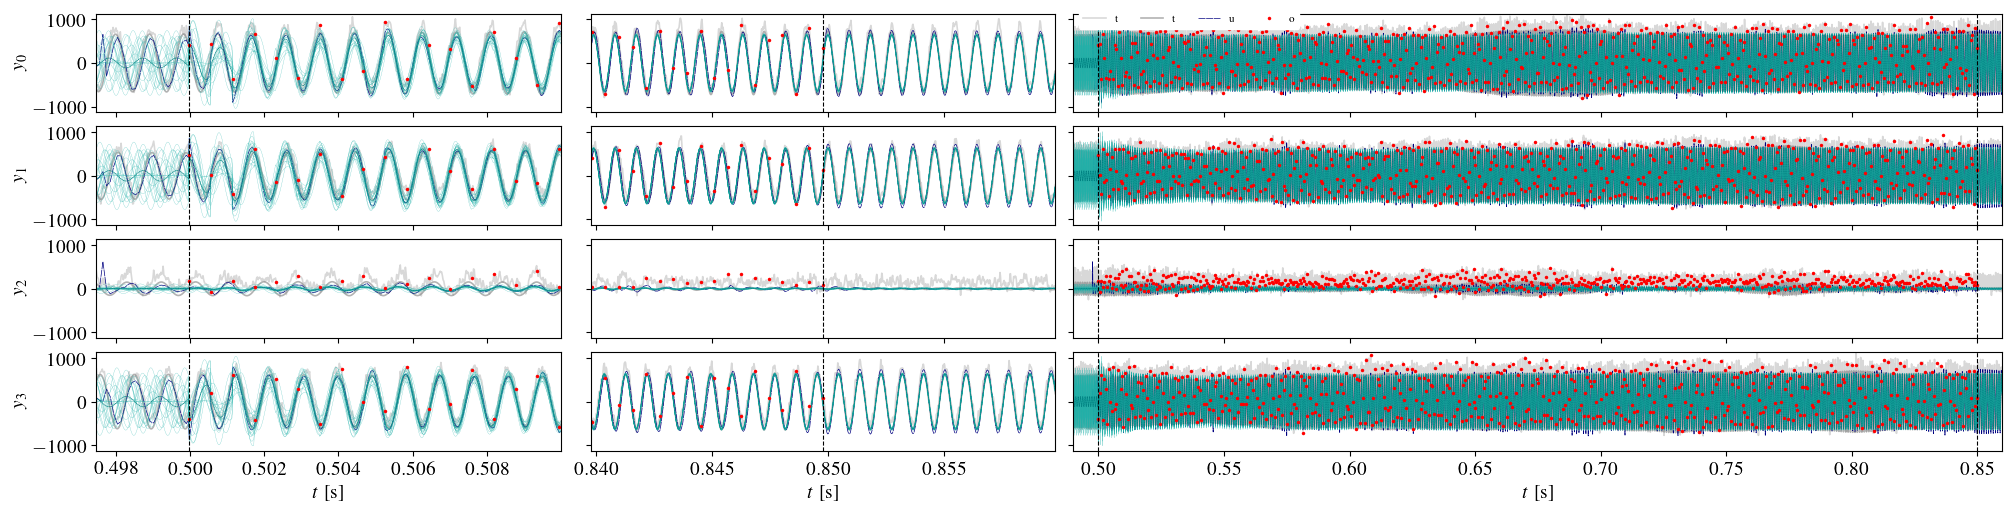

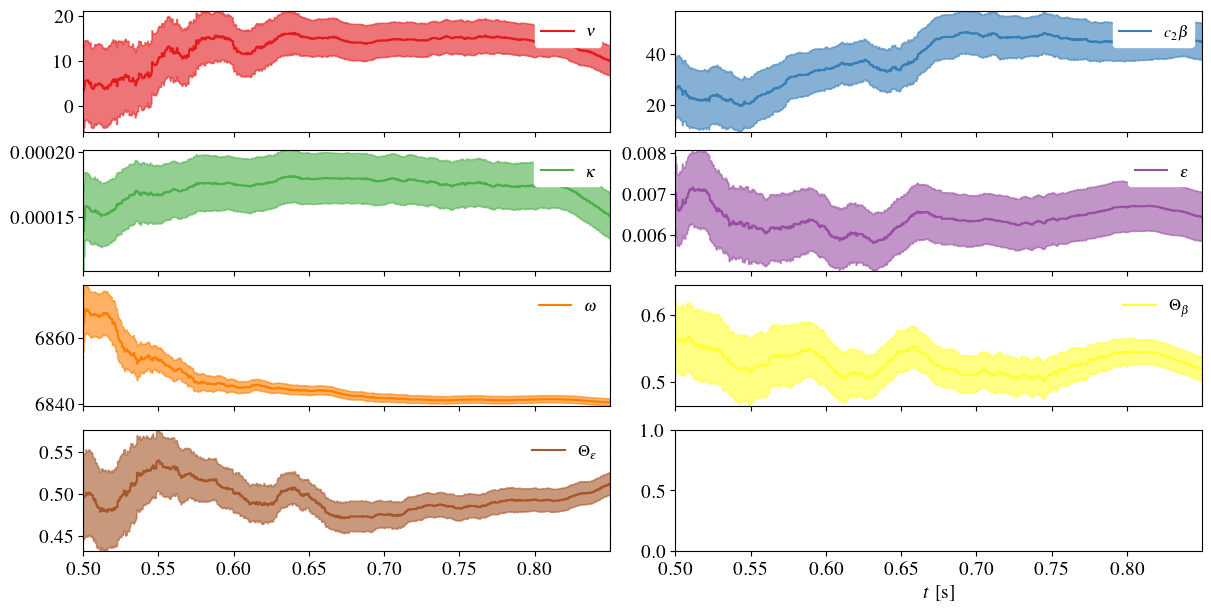

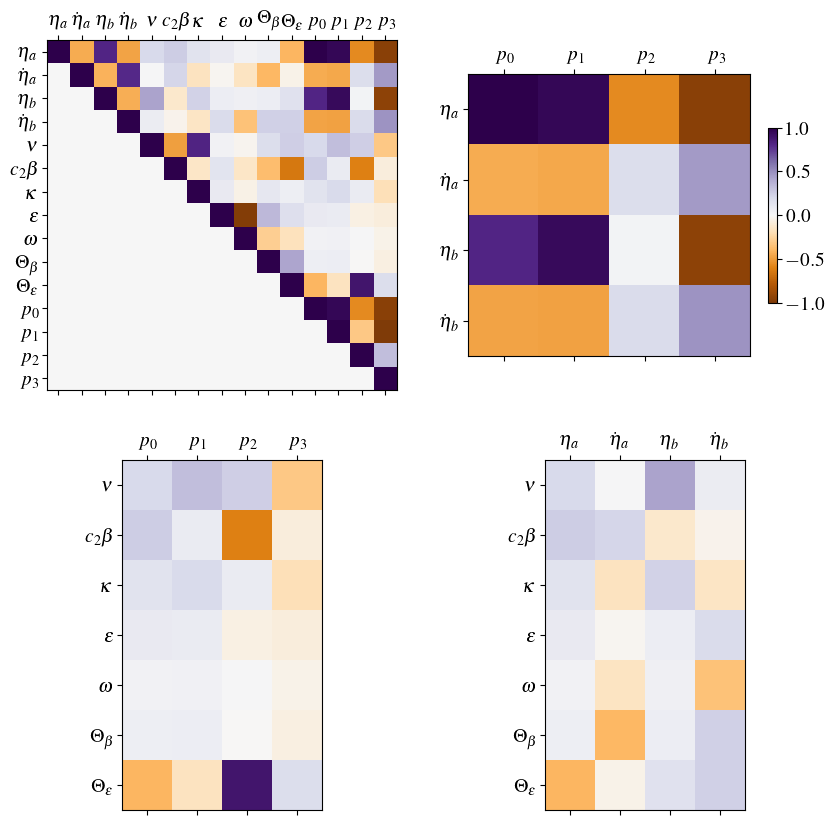

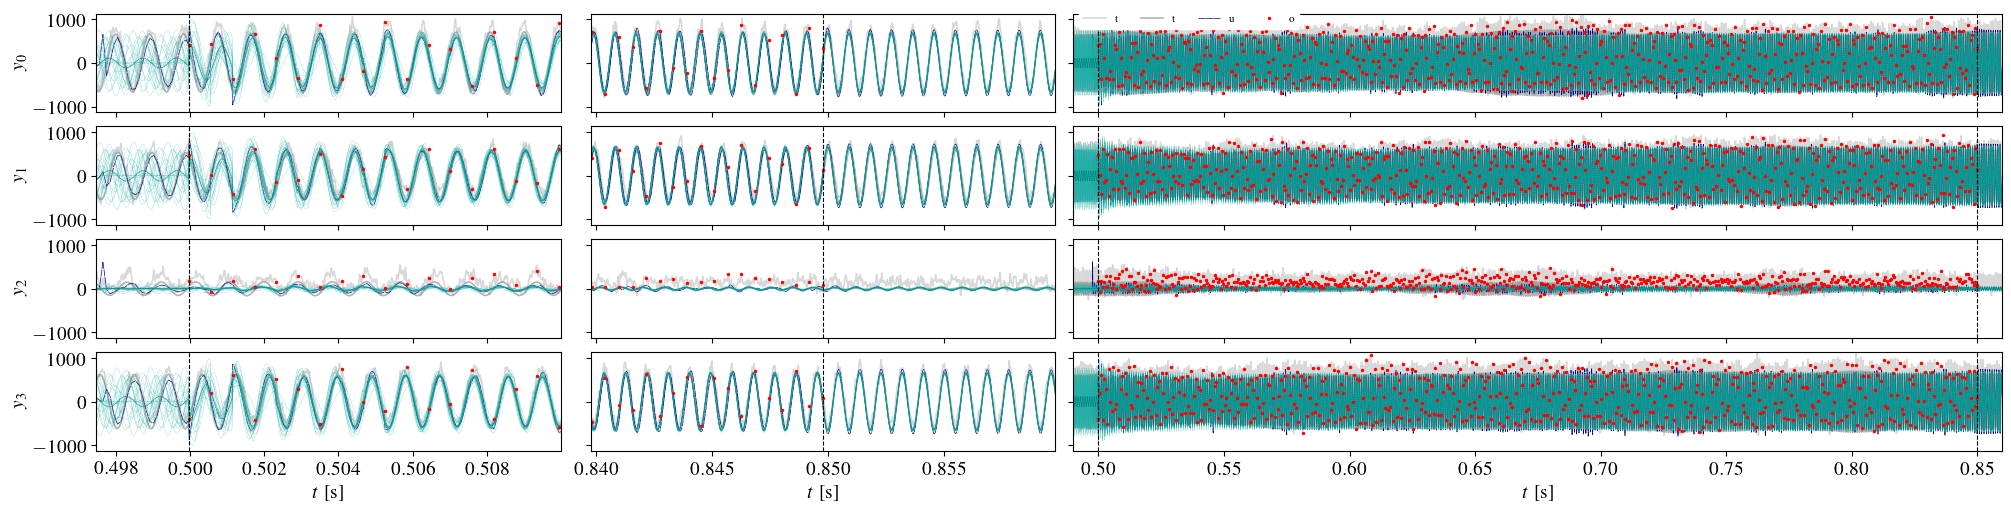

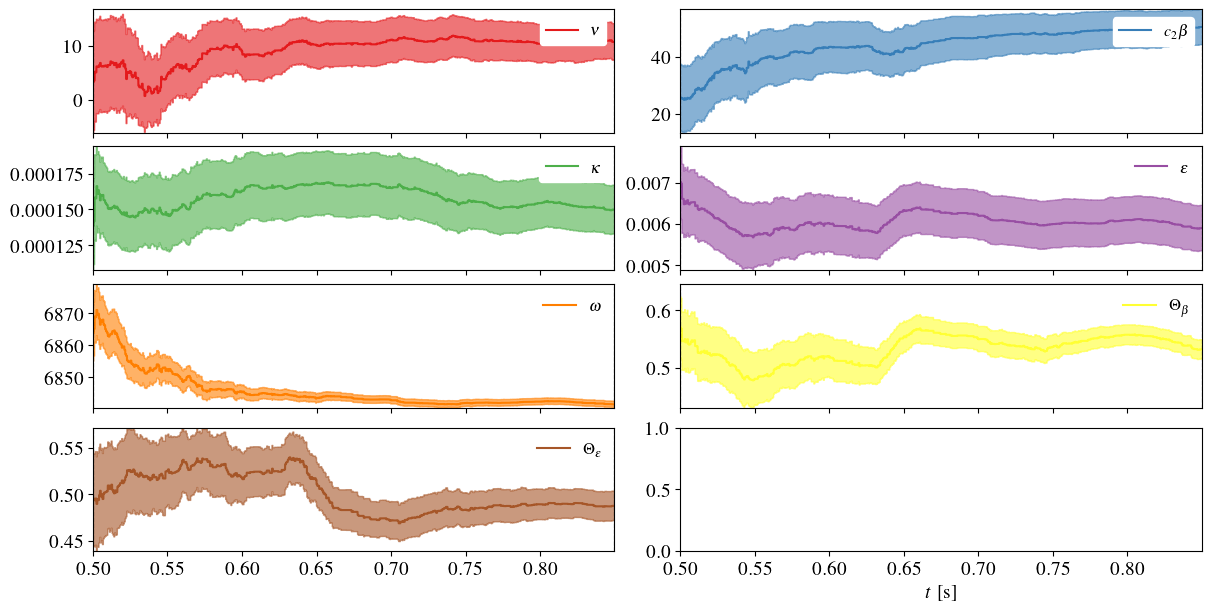

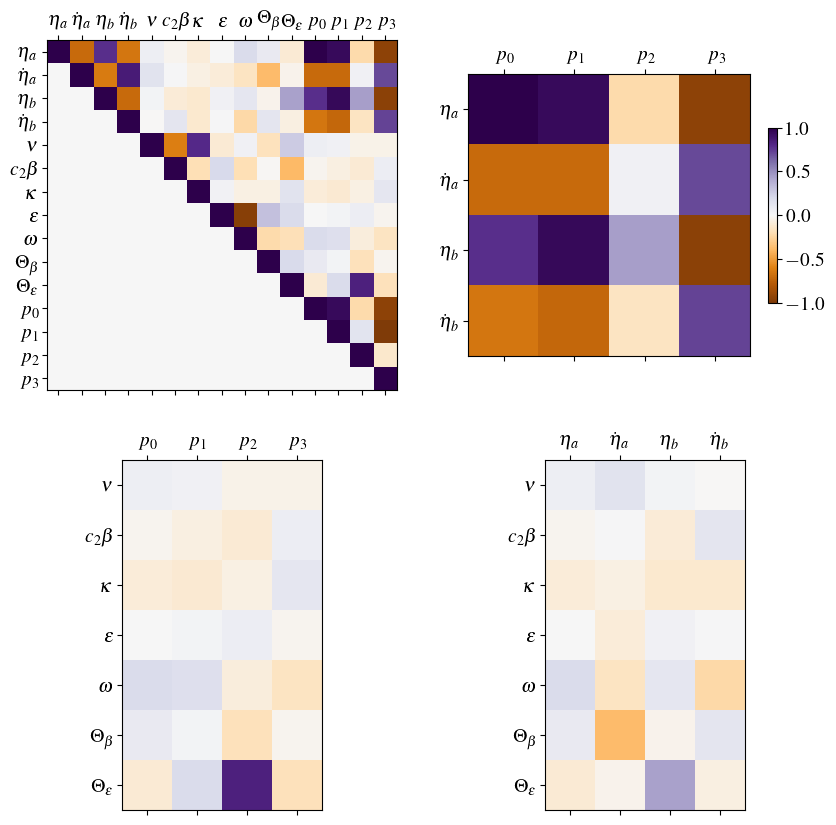

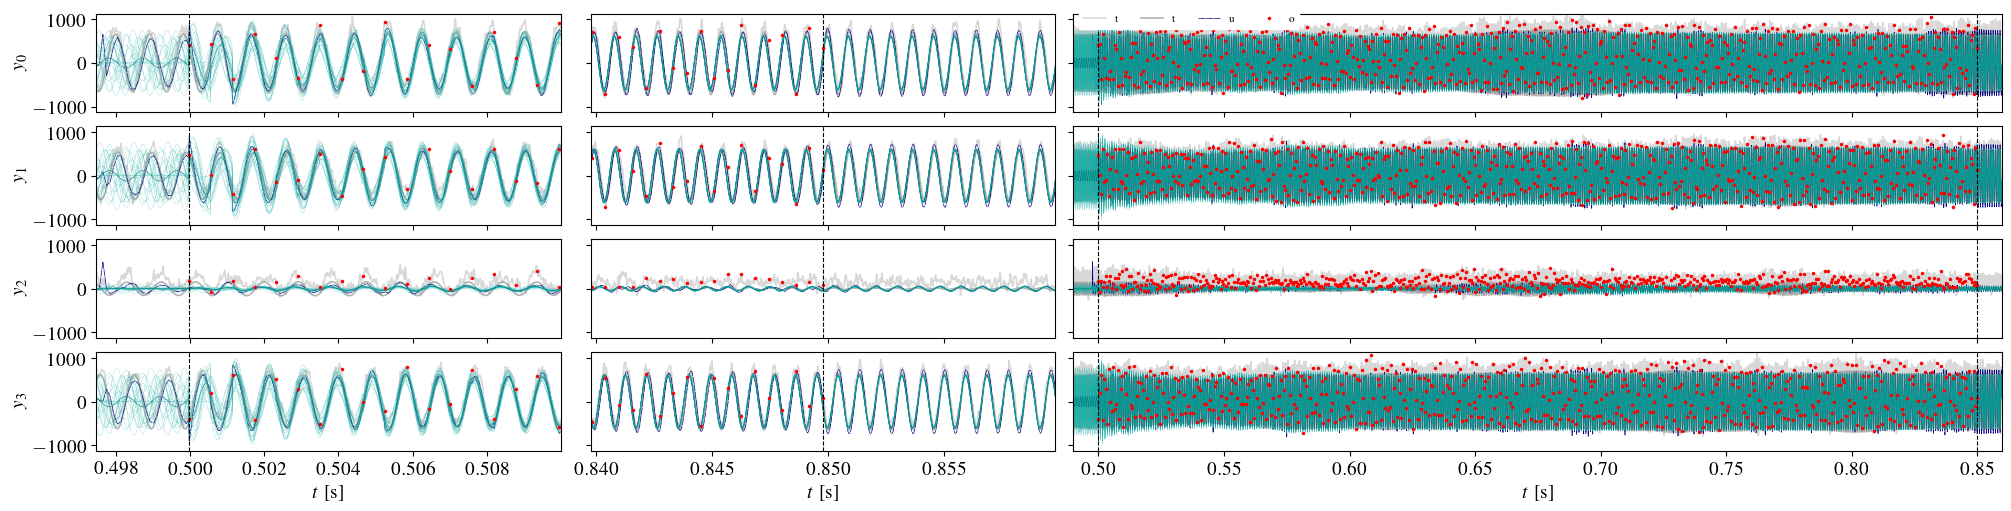

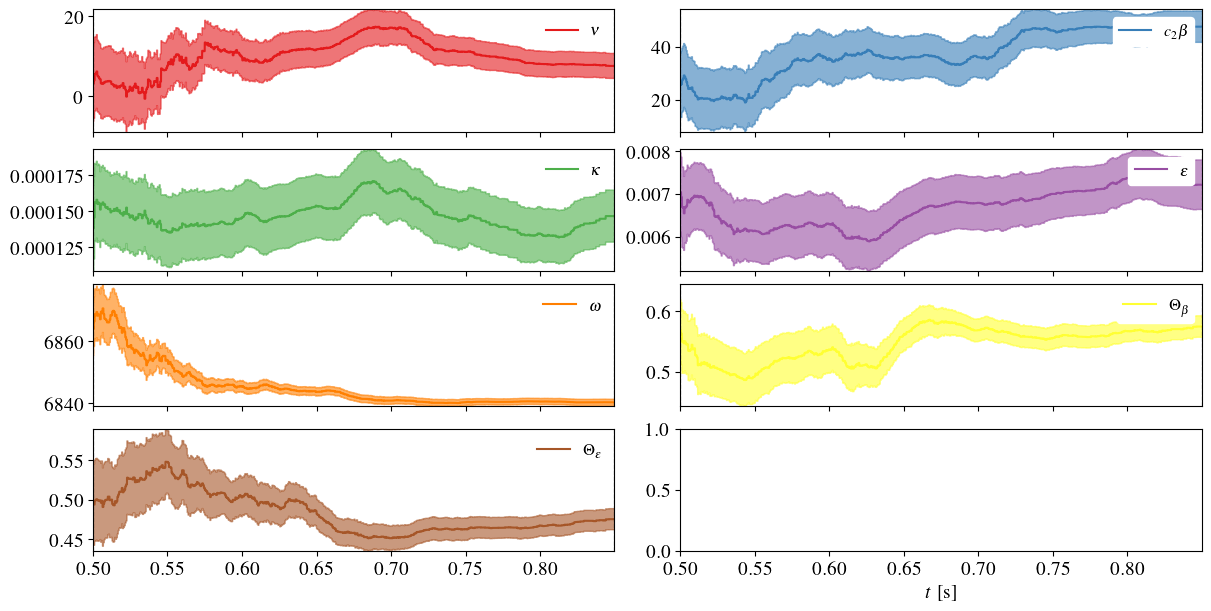

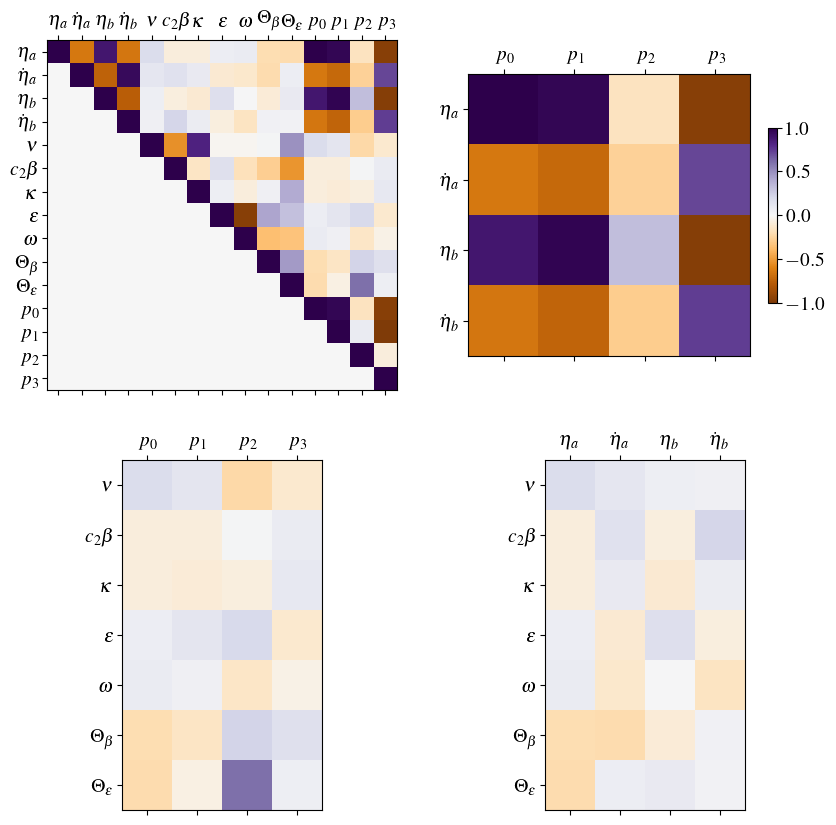

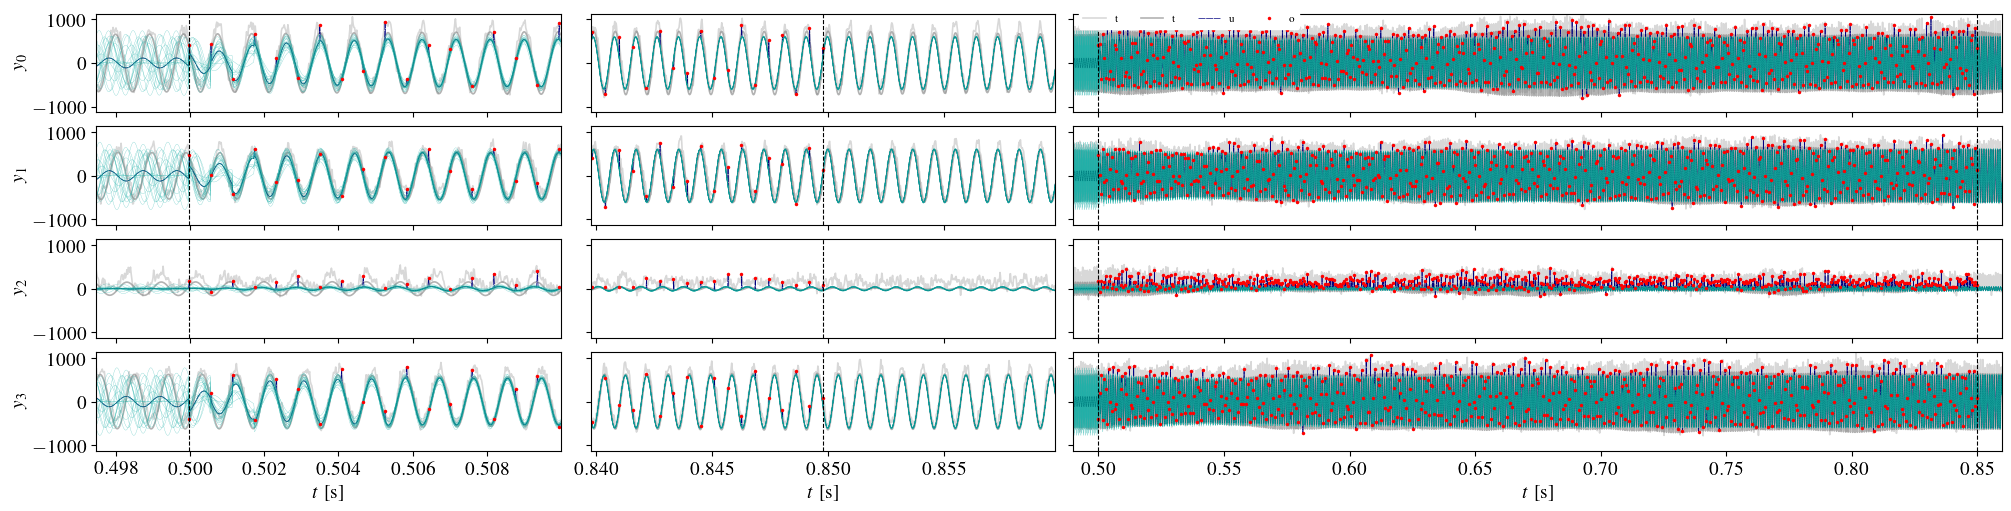

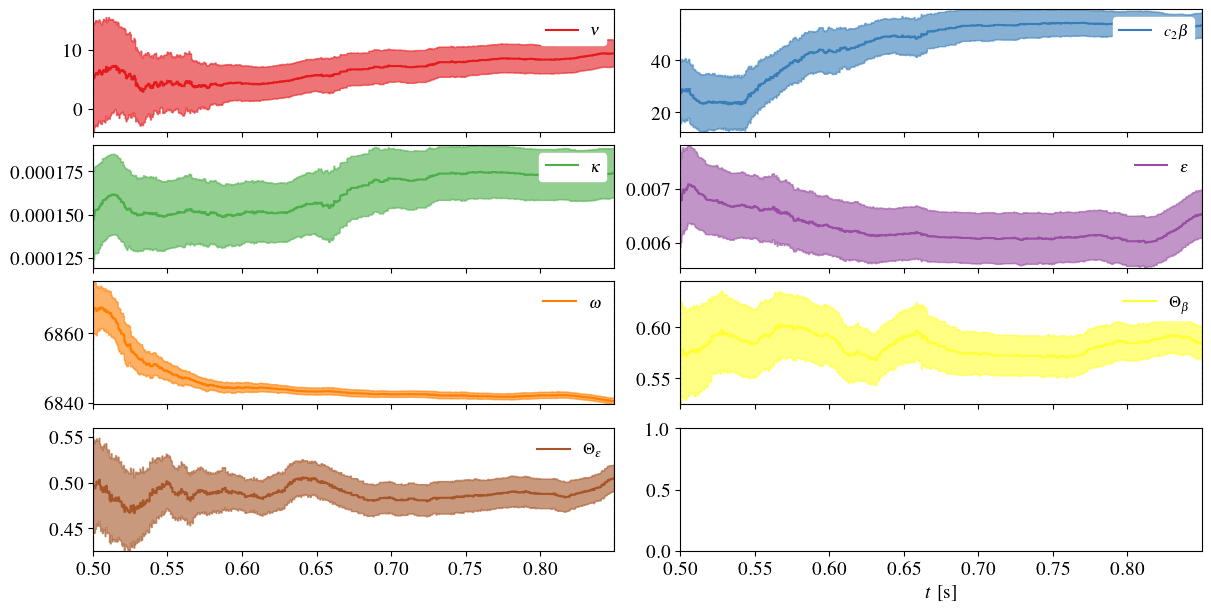

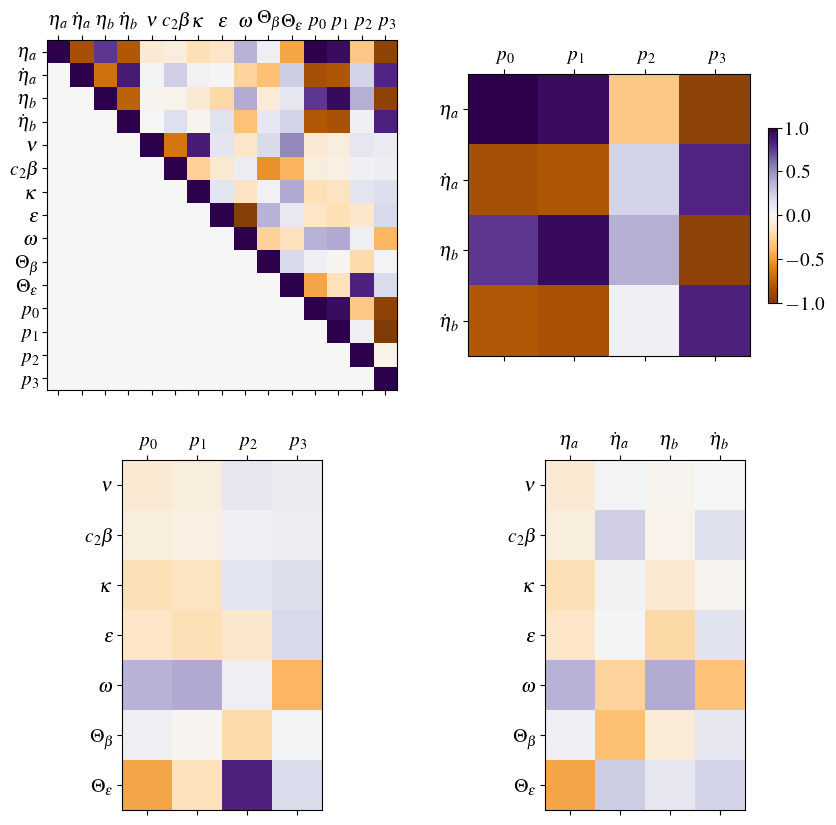

In [42]:
from essentials.plotResults import plot_timeseries, plot_parameters, plot_covarriance#

for filter_ens in out:
    plot_timeseries(filter_ens, truth_og)
    plot_parameters(filter_ens, truth_og)
    plot_covarriance(filter_ens)
    plt.show()